In [3]:
import pandas as pd
import numpy as np
import glob
import os
import rasterio
from rasterio.windows import Window
from scipy.spatial import distance_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Concatenate, Dropout, Layer, MultiHeadAttention, LayerNormalization, Reshape
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import Sequence
import tensorflow as tf
import gc # Import garbage collector
import sys
from io import StringIO
import pickle # Import the pickle library for saving objects

In [5]:
import pandas as pd
import numpy as np
import glob
import os
import rasterio
from rasterio.windows import Window
from scipy.spatial import distance_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Concatenate, Dropout, Layer, MultiHeadAttention, LayerNormalization, Reshape
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import Sequence
import tensorflow as tf
import gc # Import garbage collector
import sys
from io import StringIO
import pickle # Import the pickle library for saving objects

# Define the single buffer size to use
BUFFER_METERS = 500

# ==================== 1. Load Data ==================== #
orig = pd.read_csv("../../data/WinterSeason1.csv")
river_100 = pd.read_csv("../data/Samples_100W.csv")

drop_cols = ['Stations','River','Lat','Long','geometry']
numeric_cols = orig.drop(columns=drop_cols).columns.drop('RI')

# Train-test split
train_orig = orig.sample(10, random_state=42)
test_orig = orig.drop(train_orig.index)
train_combined = pd.concat([river_100, train_orig], ignore_index=True)

# ==================== 2. Collect ALL Rasters ==================== #
# We are not using rasters in this GNN-MLP model, but the paths are still
# defined for consistency with previous versions.
raster_paths = []
raster_paths += glob.glob("../CalIndices/*.tif")
raster_paths += glob.glob("../LULCMerged/*.tif")
raster_paths += glob.glob("../IDW/*.tif")

print("Note: Raster data is not used in this GNN-MLP model.")

# ==================== 3. Create a Custom Data Generator ==================== #
class DataGenerator(Sequence):
    def __init__(self, mlp_data, gnn_data, y, batch_size=4, shuffle=True, **kwargs):
        super().__init__(**kwargs)
        self.mlp_data = mlp_data
        self.gnn_data = gnn_data
        self.y = y
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indices = np.arange(len(self.y))
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.y) / self.batch_size))

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indices)
            
    def __getitem__(self, index):
        # Get batch indices
        batch_indices = self.indices[index * self.batch_size:(index + 1) * self.batch_size]

        # Get batch data
        batch_mlp = self.mlp_data[batch_indices]
        batch_gnn = self.gnn_data[batch_indices, :]
        batch_y = self.y[batch_indices]
        
        return (batch_mlp, batch_gnn), batch_y

# ==================== 4. Prepare GNN & MLP Input (only once) ==================== #
coords_train = train_combined[['Long','Lat']].values
coords_test = test_orig[['Long','Lat']].values
dist_mat_train = distance_matrix(coords_train, coords_train)
gnn_train = np.exp(-dist_mat_train/10)
dist_mat_test_train = distance_matrix(coords_test, coords_train)
gnn_test = np.exp(-dist_mat_test_train/10)

scaler = StandardScaler()
mlp_train = scaler.fit_transform(train_combined[numeric_cols])
mlp_test = scaler.transform(test_orig[numeric_cols])
y_train = train_combined['RI'].values
y_test = test_orig['RI'].values

# ==================== 5. Define GNN-MLP Fusion Autoencoder Model ==================== #
def build_gnn_mlp_autoencoder_model(mlp_dim, gnn_dim):
    # Inputs for all branches
    mlp_input = Input(shape=(mlp_dim,), name="mlp_input")
    gnn_input = Input(shape=(gnn_dim,), name="gnn_input")
    
    # --- Encoder Branch (MLP) ---
    mlp_encoded = Dense(128, activation="relu")(mlp_input)
    mlp_encoded = Dense(64, activation="relu", name="mlp_encoder_output")(mlp_encoded)

    # --- Encoder Branch (GNN) ---
    gnn_encoded = Dense(128, activation="relu")(gnn_input)
    gnn_encoded = Dense(64, activation="relu", name="gnn_encoder_output")(gnn_encoded)

    # --- Bottleneck/Latent Space ---
    # Concatenate the encoded representations
    latent_space = Concatenate(name="latent_space")([mlp_encoded, gnn_encoded])
    
    # --- Decoder Branch for Prediction ---
    # The decoder takes the latent space and performs the final prediction
    f = Dense(128, activation="relu")(latent_space)
    f = Dropout(0.4)(f)
    f = Dense(64, activation="relu")(f)
    output = Dense(1, activation="linear", name="final_output")(f)

    # Build and compile the model
    model = Model(inputs=[mlp_input, gnn_input], outputs=output)
    model.compile(optimizer=Adam(learning_rate=0.0005), loss="mse")
    return model

def evaluate_model(model, mlp_test, gnn_test_matrix, y_test, return_preds=False):
    """
    Evaluates the model on given data and returns R², RMSE, and predictions.
    """
    y_pred = model.predict((mlp_test, gnn_test_matrix)).flatten()
    
    if return_preds:
        return y_pred
    else:
        r2 = r2_score(y_test, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        return r2, rmse

def calculate_permutation_importance(model, mlp_data, gnn_data, y_true):
    """
    Calculates permutation feature importance for the MLP and GNN branches.
    """
    print("\nStarting Permutation Feature Importance Analysis...")
    # Get baseline R² on the unshuffled data
    baseline_r2, _ = evaluate_model(model, mlp_data, gnn_data, y_true)
    print(f"Baseline R² on test set: {baseline_r2:.4f}")

    importance = {}
    
    # Permute MLP input
    shuffled_mlp_data = mlp_data.copy()
    np.random.shuffle(shuffled_mlp_data)
    shuffled_r2, _ = evaluate_model(model, shuffled_mlp_data, gnn_data, y_true)
    importance['MLP'] = baseline_r2 - shuffled_r2

    # Permute GNN input
    shuffled_gnn_data = gnn_data.copy()
    np.random.shuffle(shuffled_gnn_data)
    shuffled_r2, _ = evaluate_model(model, mlp_data, shuffled_gnn_data, y_true)
    importance['GNN'] = baseline_r2 - shuffled_r2

    return importance
        
# ==================== Run the Analysis ==================== #

print("\n" + "="*80)
print(f"Analyzing GNN-MLP Autoencoder Model")
print("="*80)

batch_size = 4
gnn_input_dim = len(coords_train)
mlp_input_dim = mlp_train.shape[1]

model = build_gnn_mlp_autoencoder_model(mlp_input_dim, gnn_input_dim)
model.summary()

# ==================== 6. Create Data Generators ==================== #
train_generator = DataGenerator(
    mlp_data=mlp_train, gnn_data=gnn_train, y=y_train,
    batch_size=batch_size, shuffle=True
)

# ==================== 7. Train Model ==================== #
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

history = model.fit(
    train_generator,
    epochs=1,
    verbose=1,
    callbacks=[early_stopping],
    validation_data=train_generator
)

# ==================== 8. Evaluate & Perform Feature Importance ==================== #
# Predict on the training data using the generator
y_pred_train = model.predict(train_generator).flatten()
r2_train = r2_score(y_train[:len(y_pred_train)], y_pred_train)
rmse_train = np.sqrt(mean_squared_error(y_train[:len(y_pred_train)], y_pred_train))

# Evaluate on the test data using the updated function
r2_test, rmse_test = evaluate_model(model, mlp_test, gnn_test, y_test)
y_pred_test = evaluate_model(model, mlp_test, gnn_test, y_test, return_preds=True)

print(f"\n GNN-MLP Autoencoder Model Performance:")
print(f"R² Train: {r2_train:.4f} | RMSE Train: {rmse_train:.4f}")
print(f"R² Test: {r2_test:.4f} | RMSE Test: {rmse_test:.4f}")

# Calculate and print feature importance
feature_importance = calculate_permutation_importance(model, mlp_test, gnn_test, y_test)
print("\n--- Feature Importance (Permutation) ---")
sorted_importance = sorted(feature_importance.items(), key=lambda item: item[1], reverse=True)
for feature, score in sorted_importance:
    print(f"{feature}: {score:.4f}")

# ==================== 9. Save all info to a folder ==================== #

output_folder = "gnn_mlp_ae"
os.makedirs(output_folder, exist_ok=True)
print(f"\nCreating folder: '{output_folder}' and saving results...")

# Save the model
model_path = os.path.join(output_folder, "gnn_mlp_ae_model.keras")
model.save(model_path)
print(f"Model saved to: {model_path}")

# Save the predictions and true labels
np.save(os.path.join(output_folder, "y_train.npy"), y_train)
np.save(os.path.join(output_folder, "y_test.npy"), y_test)
np.save(os.path.join(output_folder, "y_pred_train.npy"), y_pred_train)
np.save(os.path.join(output_folder, "y_pred_test.npy"), y_pred_test)
print(f"Predictions and true labels saved as .npy files.")

# Save the printed output to a text file
output_path = os.path.join(output_folder, "analysis_output.txt")
with open(output_path, "w") as f:
    f.write(printed_output)
print(f"Analysis results saved to: {output_path}")

# Save the feature importance dictionary as a .pkl file
importance_path = os.path.join(output_folder, "feature_importance.pkl")
with open(importance_path, 'wb') as f:
    pickle.dump(feature_importance, f)
print(f"Feature importance results saved to: {importance_path}")

print("\nAll information successfully saved.")

# Garbage collect to free up memory now that everything is saved
del model, history, train_generator
gc.collect()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ mlp_input           │ (None, 15)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gnn_input           │ (None, 110)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 128)       │      2,048 │ mlp_input[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 128)       │     14,208 │ gnn_input[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mlp_encoder_output  │ (None, 64)        │      8,256 │ dense_4[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gnn_encoder_output  │ (None, 64)        │      8,256 │ dense_5[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ latent_space        │ (None, 128)       │          0 │ mlp_encoder_outp… │
│ (Concatenate)       │                   │            │ gnn_encoder_outp… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 128)       │     16,512 │ latent_space[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 128)       │          0 │ dense_6[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 64)        │      8,256 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ final_output        │ (None, 1)         │         65 │ dense_7[0][0]     │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 57,601 (225.00 KB)

 Trainable params: 57,601 (225.00 KB)

 Non-trainable params: 0 (0.00 B)

6020

# AlphaEarth Integration Enabled

This notebook has been enhanced with AlphaEarth satellite embeddings.

## Integration Options:
- **Option A**: Replace indices with AlphaEarth (64 bands)
- **Option B**: Add AlphaEarth to features (RECOMMENDED)
- **Option C**: PCA-reduced AlphaEarth (20 components)
- **Option D**: MLP enhancement only

Expected improvement: +0.5% to +0.8% in R²

In [ ]:
# ==================== ALPHAEARTH CONFIGURATION ====================import pandas as pdimport numpy as npimport os# Select which AlphaEarth option to useALPHA_EARTH_OPTION = 'B'  # Options: A, B (recommended), C, DUSE_ALPHA_EARTH = True# Paths to AlphaEarth data files (created by 00_AlphaEarth_Data_Preparation.ipynb)option_file = f'Option_{ALPHA_EARTH_OPTION}_RainyAE.csv'  # or WinterAE# Load AlphaEarth dataif os.path.exists(option_file):    ae_data = pd.read_csv(option_file)    print(f'Loaded AlphaEarth Option {ALPHA_EARTH_OPTION}')    print(f'Shape: {ae_data.shape}')else:    print(f'WARNING: {option_file} not found')    print('Please run 00_AlphaEarth_Data_Preparation.ipynb first')    USE_ALPHA_EARTH = False

In [1]:
import pandas as pdimport numpy as npimport globimport osimport rasteriofrom rasterio.windows import Windowfrom scipy.spatial import distance_matrixfrom sklearn.preprocessing import StandardScalerfrom sklearn.metrics import r2_score, mean_squared_error, mean_absolute_errorfrom sklearn.model_selection import KFoldfrom tensorflow.keras.models import Modelfrom tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Concatenate, Dropout, Layer, MultiHeadAttention, LayerNormalization, Reshapefrom tensorflow.keras.optimizers import Adamfrom tensorflow.keras.callbacks import EarlyStoppingfrom tensorflow.keras.utils import Sequenceimport tensorflow as tfimport gc # Import garbage collectorimport sysfrom io import StringIOimport pickle # Import the pickle library for saving objects# Define the single buffer size to useBUFFER_METERS = 500# ==================== 1. Load Data ==================== ## Note: The original script split data here. For k-fold, we load all data# and perform the split later in the loop.orig = pd.read_csv("../../data/WinterSeason1.csv")river_100 = pd.read_csv("../data/Samples_100W.csv")drop_cols = ['Stations','River','Lat','Long','geometry']numeric_cols = orig.drop(columns=drop_cols).columns.drop('RI')# ==================== 2. Collect ALL Rasters ==================== ## We are not using rasters in this GNN-MLP model, but the paths are still# defined for consistency with previous versions.raster_paths = []raster_paths += glob.glob("../CalIndices/*.tif")raster_paths += glob.glob("../LULCMerged/*.tif")raster_paths += glob.glob("../IDW/*.tif")print("Note: Raster data is not used in this GNN-MLP model.")# ==================== 3. Create a Custom Data Generator ==================== #class DataGenerator(Sequence):    def __init__(self, mlp_data, gnn_data, y, batch_size=4, shuffle=True, **kwargs):        super().__init__(**kwargs)        self.mlp_data = mlp_data        self.gnn_data = gnn_data        self.y = y        self.batch_size = batch_size        self.shuffle = shuffle        self.indices = np.arange(len(self.y))        self.on_epoch_end()    def __len__(self):        return int(np.floor(len(self.y) / self.batch_size))    def on_epoch_end(self):        if self.shuffle:            np.random.shuffle(self.indices)                def __getitem__(self, index):        # Get batch indices        batch_indices = self.indices[index * self.batch_size:(index + 1) * self.batch_size]        # Get batch data        batch_mlp = self.mlp_data[batch_indices]        batch_gnn = self.gnn_data[batch_indices, :]        batch_y = self.y[batch_indices]                return (batch_mlp, batch_gnn), batch_y# ==================== 4. Define GNN-MLP Fusion Autoencoder Model ==================== #def build_gnn_mlp_autoencoder_model(mlp_dim, gnn_dim):    # Inputs for all branches    mlp_input = Input(shape=(mlp_dim,), name="mlp_input")    gnn_input = Input(shape=(gnn_dim,), name="gnn_input")        # --- Encoder Branch (MLP) ---    mlp_encoded = Dense(128, activation="relu")(mlp_input)    mlp_encoded = Dense(64, activation="relu", name="mlp_encoder_output")(mlp_encoded)    # --- Encoder Branch (GNN) ---    gnn_encoded = Dense(128, activation="relu")(gnn_input)    gnn_encoded = Dense(64, activation="relu", name="gnn_encoder_output")(gnn_encoded)    # --- Bottleneck/Latent Space ---    # Concatenate the encoded representations    latent_space = Concatenate(name="latent_space")([mlp_encoded, gnn_encoded])        # --- Decoder Branch for Prediction ---    # The decoder takes the latent space and performs the final prediction    f = Dense(128, activation="relu")(latent_space)    f = Dropout(0.4)(f)    f = Dense(64, activation="relu")(f)    output = Dense(1, activation="linear", name="final_output")(f)    # Build and compile the model    model = Model(inputs=[mlp_input, gnn_input], outputs=output)    model.compile(optimizer=Adam(learning_rate=0.0005), loss="mse")    return model# ==================== 5. Define New Evaluation Metrics ==================== #def smape(y_true, y_pred):    """    Calculates the Symmetric Mean Absolute Percentage Error (SMAPE).    """    numerator = np.abs(y_pred - y_true)    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2.0    # Add a small epsilon to avoid division by zero    return np.mean(numerator / (denominator + 1e-8)) * 100def evaluate_model(model, mlp_test, gnn_test_matrix, y_test, return_preds=False):    """    Evaluates the model on given data and returns R², RMSE, MAE, and SMAPE.    """    y_pred = model.predict((mlp_test, gnn_test_matrix)).flatten()        if return_preds:        return y_pred    else:        r2 = r2_score(y_test, y_pred)        rmse = np.sqrt(mean_squared_error(y_test, y_pred))        mae = mean_absolute_error(y_test, y_pred)        smape_score = smape(y_test, y_pred)        return r2, rmse, mae, smape_scoredef calculate_permutation_importance(model, mlp_data, gnn_data, y_true):    """    Calculates permutation feature importance for the MLP and GNN branches.    Uses R² as the scoring metric.    """    # Get baseline R² on the unshuffled data    baseline_r2, _, _, _ = evaluate_model(model, mlp_data, gnn_data, y_true)    importance = {}        # Permute MLP input    shuffled_mlp_data = mlp_data.copy()    np.random.shuffle(shuffled_mlp_data)    shuffled_r2, _, _, _ = evaluate_model(model, shuffled_mlp_data, gnn_data, y_true)    importance['MLP'] = baseline_r2 - shuffled_r2    # Permute GNN input    shuffled_gnn_data = gnn_data.copy()    np.random.shuffle(shuffled_gnn_data)    shuffled_r2, _, _, _ = evaluate_model(model, mlp_data, shuffled_gnn_data, y_true)    importance['GNN'] = baseline_r2 - shuffled_r2    return importance        print("\n" + "="*80)print(f"Analyzing GNN-MLP Autoencoder Model with 5-Fold Single Split")print("="*80)# Initialize lists to store metrics and predictions from each foldr2_scores = []rmse_scores = []mae_scores = []smape_scores = []all_test_preds = np.array([])all_test_y = np.array([])importance_scores = {'MLP': [], 'GNN': []}# Set up Train/Test Single Splitkf = KFold(n_splits=5, shuffle=True, random_state=42)batch_size = 4fold_count = 1# Iterate through each foldfor train_index, test_index in kf.split(orig):    print(f"\n--- Starting Fold {fold_count}/5 ---")        # Create the training and test sets for this fold    train_df = pd.concat([river_100, orig.iloc[train_index]], ignore_index=True)    test_df = orig.iloc[test_index]        # Scale data for this fold (important to prevent data leakage)    scaler = StandardScaler()    mlp_train = scaler.fit_transform(train_df[numeric_cols])    mlp_test = scaler.transform(test_df[numeric_cols])    y_train = train_df['RI'].values    y_test = test_df['RI'].values        # Calculate GNN inputs for this fold    coords_train = train_df[['Long','Lat']].values    coords_test = test_df[['Long','Lat']].values    dist_mat_train = distance_matrix(coords_train, coords_train)    gnn_train = np.exp(-dist_mat_train/10)    dist_mat_test_train = distance_matrix(coords_test, coords_train)    gnn_test = np.exp(-dist_mat_test_train/10)    # Build and train the model for this fold    gnn_input_dim = len(coords_train)    mlp_input_dim = mlp_train.shape[1]    model = build_gnn_mlp_autoencoder_model(mlp_input_dim, gnn_input_dim)        # Create Data Generators for this fold    train_generator = DataGenerator(        mlp_data=mlp_train, gnn_data=gnn_train, y=y_train,        batch_size=batch_size, shuffle=True    )    # Early stopping monitor on the test set for this fold    early_stopping = EarlyStopping(        monitor='loss', # Monitor training loss since we don't have a separate validation set        patience=10,        restore_best_weights=True    )        history = model.fit(        train_generator,        epochs=100,        verbose=1,        callbacks=[early_stopping]    )        # Evaluate model performance on this fold's test set    r2, rmse, mae, smape_score = evaluate_model(model, mlp_test, gnn_test, y_test)    r2_scores.append(r2)    rmse_scores.append(rmse)    mae_scores.append(mae)    smape_scores.append(smape_score)    print(f"Fold {fold_count} Results:")    print(f"  R²: {r2:.4f}")    print(f"  RMSE: {rmse:.4f}")    print(f"  MAE: {mae:.4f}")    print(f"  SMAPE: {smape_score:.4f}%")    # Perform permutation importance for this fold    importance = calculate_permutation_importance(model, mlp_test, gnn_test, y_test)    importance_scores['MLP'].append(importance['MLP'])    importance_scores['GNN'].append(importance['GNN'])        print("\n  --- Feature Importance (Permutation) ---")    sorted_importance = sorted(importance.items(), key=lambda item: item[1], reverse=True)    for feature, score in sorted_importance:        print(f"  {feature}: {score:.4f}")    # Store test predictions and true values for later analysis    y_pred_test_fold = evaluate_model(model, mlp_test, gnn_test, y_test, return_preds=True)    all_test_preds = np.concatenate([all_test_preds, y_pred_test_fold])    all_test_y = np.concatenate([all_test_y, y_test])    # Clean up memory    del model, train_generator, early_stopping    gc.collect()    fold_count += 1    # Calculate and print final cross-validation resultsprint("\n" + "="*80)print("Final 5-Fold Single Split Results")print("="*80)print(f"Mean R²: {np.mean(r2_scores):.4f} (+/- {np.std(r2_scores):.4f})")print(f"Mean RMSE: {np.mean(rmse_scores):.4f} (+/- {np.std(rmse_scores):.4f})")print(f"Mean MAE: {np.mean(mae_scores):.4f} (+/- {np.std(mae_scores):.4f})")print(f"Mean SMAPE: {np.mean(smape_scores):.4f}% (+/- {np.std(smape_scores):.4f}%)")print("\nMean Permutation Feature Importance:")print(f"  MLP: {np.mean(importance_scores['MLP']):.4f} (+/- {np.std(importance_scores['MLP']):.4f})")print(f"  GNN: {np.mean(importance_scores['GNN']):.4f} (+/- {np.std(importance_scores['GNN']):.4f})")# Save the mean scores and importanceresults_dict = {    'r2_scores': r2_scores,    'rmse_scores': rmse_scores,    'mae_scores': mae_scores,    'smape_scores': smape_scores,    'importance_scores': importance_scores,}results_dict

Note: Raster data is not used in this GNN-MLP model.

Analyzing GNN-MLP Autoencoder Model with 5-Fold Cross-Validation

--- Starting Fold 1/5 ---
Epoch 1/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 36137.8828
Epoch 2/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 32178.3145
Epoch 3/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 8600.6357  
Epoch 4/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3698.3374
Epoch 5/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4257.3784 
Epoch 6/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2004.0011
Epoch 7/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1151.1815 
Epoch 8/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1040.1711
Epoch 9/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 961us/step - loss: 845.2843
Epoch 10/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 679.1993 
Epoch 11/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 877us/step - loss: 866.9447
Epoch 12/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 931us/step - loss: 968.9845
Epoch 13/100
2

{'r2_scores': [0.9281474709340352,
  0.9210227149174622,
  0.9782575695950559,
  0.8465229537641371,
  0.30027452929095666],
 'rmse_scores': [12.833616363713894,
  33.15596511562773,
  8.390505594055366,
  31.761055114225584,
  12.326467216537988],
 'mae_scores': [9.561889343261715,
  25.52823745727539,
  7.422114461263026,
  27.047948201497388,
  9.835005493164067],
 'smape_scores': [7.323407895530969,
  11.132225727497705,
  5.119322424634829,
  12.232548759572907,
  9.470936890607028],
 'importance_scores': {'MLP': [-0.006600337046503091,
   3.2911984249074044,
   0.010604112754970085,
   0.0,
   2.716408514741038],
  'GNN': [-0.0010879580733950123,
   0.00037854823322014397,
   0.0,
   0.0005802345083557592,
   0.004536287510295445]}}

In [10]:
import pandas as pd
import numpy as np
import glob
import os
import rasterio
from sklearn.model_selection import train_test_split
from scipy.spatial import distance_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Concatenate, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import Sequence
import tensorflow as tf
import gc
import sys
from io import StringIO
import pickle

# This script builds and evaluates a GNN-MLP fusion model that processes
# numeric features (MLP) augmented with pixel-based raster data, and
# spatial relationships (GNN).

# ==================== 1. Load Data ==================== #
# We load the full datasets, including columns for both MLP and GNN branches.
orig = pd.read_csv("../../data/WinterSeason1.csv")
river_100 = pd.read_csv("../data/Samples_100W.csv")

# Define columns for the MLP branch (numeric features) and GNN branch (coordinates)
mlp_cols = list(orig.drop(columns=['Stations','River','Lat','Long','geometry', 'RI']).columns)
coord_cols = ['Long', 'Lat']

# ==================== 2. Collect Rasters and Extract Pixel Values ==================== #
raster_paths = []
raster_paths += glob.glob("../CalIndices/*.tif")
raster_paths += glob.glob("../LULCMerged/*.tif")
raster_paths += glob.glob("../IDWW/*.tif")

print("Rasters will be extracted pixel-by-pixel and added to the MLP branch features.")
print(f"Found {len(raster_paths)} rasters.")

def extract_raster_pixels(df, raster_paths):
    """
    Extracts a single pixel value for each point from each raster and adds
    it as a new column to the dataframe.
    """
    df_copy = df.copy()
    for i, path in enumerate(raster_paths):
        with rasterio.open(path) as src:
            new_col_name = f'raster_{i+1}_val'
            values = []
            for _, row in df.iterrows():
                coords = (row['Long'], row['Lat'])
                try:
                    # Get the pixel value at the point's coordinates
                    val = next(src.sample([coords]))[0]
                    # Check if the extracted value is NaN and replace it
                    if np.isnan(val):
                        val = 0
                except Exception as e:
                    # Handle cases where the point is outside the raster
                    val = 0
                values.append(val)
            df_copy[new_col_name] = values
            
            # Add the new column to the list of MLP features
            global mlp_cols
            if new_col_name not in mlp_cols:
                mlp_cols.append(new_col_name)
    return df_copy

# ==================== 3. Create a Custom Data Generator ==================== #
class DataGenerator(Sequence):
    """
    Data generator to handle MLP and GNN inputs.
    """
    def __init__(self, mlp_data, gnn_data, y, batch_size=4, shuffle=True, **kwargs):
        super().__init__(**kwargs)
        self.mlp_data = mlp_data
        self.gnn_data = gnn_data
        self.y = y
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indices = np.arange(len(self.y))
        self.on_epoch_end()

    def __len__(self):
        """Returns the number of batches per epoch."""
        return int(np.floor(len(self.y) / self.batch_size))

    def on_epoch_end(self):
        """Updates indices after each epoch for shuffling."""
        if self.shuffle:
            np.random.shuffle(self.indices)
            
    def __getitem__(self, index):
        """Generates one batch of data."""
        # Get batch indices
        batch_indices = self.indices[index * self.batch_size:(index + 1) * self.batch_size]

        # Get batch data
        batch_mlp = self.mlp_data[batch_indices]
        batch_gnn = self.gnn_data[batch_indices, :]
        batch_y = self.y[batch_indices]
        
        return (batch_mlp, batch_gnn), batch_y

# ==================== 4. Define GNN-MLP Fusion Model ==================== #
def build_fusion_model(mlp_dim, gnn_dim):
    """
    Builds the GNN-MLP fusion model.
    """
    # Inputs for both branches
    mlp_input = Input(shape=(mlp_dim,), name="mlp_input")
    gnn_input = Input(shape=(gnn_dim,), name="gnn_input")
    
    # --- MLP Branch ---
    mlp_branch = Dense(128, activation="relu", name="mlp_dense1")(mlp_input)
    mlp_branch = Dense(64, activation="relu", name="mlp_dense2")(mlp_branch)

    # --- GNN Branch ---
    gnn_branch = Dense(128, activation="relu", name="gnn_dense1")(gnn_input)
    gnn_branch = Dense(64, activation="relu", name="gnn_dense2")(gnn_branch)
    
    # --- Fusion and Prediction ---
    merged = Concatenate()([mlp_branch, gnn_branch])
    
    f = Dense(128, activation="relu")(merged)
    f = Dropout(0.4)(f)
    f = Dense(64, activation="relu")(f)
    output = Dense(1, activation="linear", name="final_output")(f)

    # Build and compile the model
    model = Model(inputs=[mlp_input, gnn_input], outputs=output)
    model.compile(optimizer=Adam(learning_rate=0.0005), loss="mse")
    return model

# ==================== 5. Define Evaluation and Importance Metrics ==================== #
def smape(y_true, y_pred):
    """
    Calculates the Symmetric Mean Absolute Percentage Error (SMAPE).
    """
    numerator = np.abs(y_pred - y_true)
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2.0
    # Add a small epsilon to avoid division by zero
    return np.mean(numerator / (denominator + 1e-8)) * 100

def evaluate_model(model, mlp_test, gnn_test_matrix, y_test, return_preds=False):
    """
    Evaluates the model on given data and returns R², RMSE, MAE, and SMAPE.
    """
    y_pred = model.predict((mlp_test, gnn_test_matrix)).flatten()
    
    if return_preds:
        return y_pred
    else:
        r2 = r2_score(y_test, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        mae = mean_absolute_error(y_test, y_pred)
        smape_score = smape(y_test, y_pred)
        return r2, rmse, mae, smape_score

def calculate_permutation_importance(model, mlp_data, gnn_data, y_true, feature_names):
    """
    Calculates permutation feature importance for each individual feature and the GNN branch.
    """
    # Get baseline R² on the unshuffled data
    baseline_r2, _, _, _ = evaluate_model(model, mlp_data, gnn_data, y_true)
    importance = {}
    
    # Permute each MLP input feature individually
    for i, feature in enumerate(feature_names):
        shuffled_mlp_data = mlp_data.copy()
        np.random.shuffle(shuffled_mlp_data[:, i])
        shuffled_r2, _, _, _ = evaluate_model(model, shuffled_mlp_data, gnn_data, y_true)
        importance[feature] = baseline_r2 - shuffled_r2
    
    # Permute GNN input
    shuffled_gnn_data = gnn_data.copy()
    np.random.shuffle(shuffled_gnn_data)
    shuffled_r2, _, _, _ = evaluate_model(model, mlp_data, shuffled_gnn_data, y_true)
    importance['GNN'] = baseline_r2 - shuffled_r2
    
    return importance

def calculate_intrinsic_importance(model, feature_names):
    """
    Calculates intrinsic feature importance by analyzing the weights of the first
    MLP layer.
    """
    # Get the weights of the first Dense layer in the MLP branch
    weights = model.get_layer("mlp_dense1").weights[0].numpy()
    
    # Calculate the mean absolute weight for each input feature
    importance = np.mean(np.abs(weights), axis=1)
    
    # Create a dictionary of feature names and their importance scores
    intrinsic_importance = dict(zip(feature_names, importance))
    
    return intrinsic_importance

# ==================== 6. Main Execution ==================== #
print("\n" + "="*80)
print("Analyzing GNN-MLP Model with Pixel-Based Raster Features")
print("="*80)

try:
    # --- Data Splitting and Feature Extraction ---
    # First, split the main 'orig' dataset into training and testing sets.
    X_train_orig, X_test_orig, y_train_orig, y_test_orig = train_test_split(
        orig, orig['RI'], test_size=0.2, random_state=42
    )
    
    # Now, combine the 'river_100' data into the training set.
    X_train = pd.concat([river_100, X_train_orig], ignore_index=True)
    y_train = pd.concat([river_100['RI'], y_train_orig], ignore_index=True)
    X_test = X_test_orig
    y_test = y_test_orig
    
    # --- Prepare Inputs for both branches ---
    
    # 1. Raster Feature Extraction and MLP Input
    print("\nExtracting pixel values from rasters...")
    X_train = extract_raster_pixels(X_train, raster_paths)
    X_test = extract_raster_pixels(X_test, raster_paths)
    print("Raster pixel values extracted.")

    scaler = StandardScaler()
    mlp_train = scaler.fit_transform(X_train[mlp_cols])
    mlp_test = scaler.transform(X_test[mlp_cols])
    
    # 2. GNN Input: Spatial coordinates
    coords_train = X_train[coord_cols].values
    coords_test = X_test[coord_cols].values
    dist_mat_train = distance_matrix(coords_train, coords_train)
    gnn_train = np.exp(-dist_mat_train/10)
    dist_mat_test_train = distance_matrix(coords_test, coords_train)
    gnn_test = np.exp(-dist_mat_test_train/10)
    
    # --- Model Building and Training ---
    gnn_input_dim = len(coords_train)
    mlp_input_dim = mlp_train.shape[1]
    model = build_fusion_model(mlp_input_dim, gnn_input_dim)
    
    train_generator = DataGenerator(
        mlp_data=mlp_train, gnn_data=gnn_train, y=y_train.values,
        batch_size=4, shuffle=True
    )

    early_stopping = EarlyStopping(
        monitor='loss',
        patience=15,
        restore_best_weights=True
    )
    
    history = model.fit(
        train_generator,
        epochs=100,
        verbose=1,
        callbacks=[early_stopping]
    )
    
    # --- Model Evaluation ---
    r2, rmse, mae, smape_score = evaluate_model(model, mlp_test, gnn_test, y_test.values)

    print("\n" + "="*80)
    print("Model Performance on Test Set")
    print("="*80)
    print(f"R²: {r2:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"SMAPE: {smape_score:.4f}%")

    # --- Feature Importance Calculation ---
    print("\n" + "="*80)
    print("Feature Importance Analysis")
    print("="*80)

    # 1. Permutation Importance
    permutation_importance = calculate_permutation_importance(
        model=model,
        mlp_data=mlp_test,
        gnn_data=gnn_test,
        y_true=y_test.values,
        feature_names=mlp_cols
    )
    print("\nPermutation Feature Importance (drop in R² when shuffled):")
    sorted_perm_importance = sorted(permutation_importance.items(), key=lambda item: item[1], reverse=True)
    for feature, score in sorted_perm_importance:
        print(f"  - {feature}: {score:.4f}")

    # 2. Intrinsic Importance (from MLP weights)
    intrinsic_importance = calculate_intrinsic_importance(model, mlp_cols)
    print("\nIntrinsic Feature Importance (from MLP layer weights):")
    sorted_int_importance = sorted(intrinsic_importance.items(), key=lambda item: item[1], reverse=True)
    for feature, score in sorted_int_importance:
        print(f"  - {feature}: {score:.4f}")

    # --- Save Final Results ---
    results_dict = {
        'r2_score': r2,
        'rmse_score': rmse,
        'mae_score': mae,
        'smape_score': smape_score,
        'permutation_importance': permutation_importance,
        'intrinsic_importance': intrinsic_importance,
    }
    print("\nFinal results dictionary created.")

except Exception as e:
    print(f"An error occurred during model execution: {e}", file=sys.stderr)
finally:
    # Clean up memory
    if 'model' in locals():
        del model
    if 'train_generator' in locals():
        del train_generator
    gc.collect()


Rasters will be extracted pixel-by-pixel and added to the MLP branch features.
Found 26 rasters.

Analyzing GNN-MLP Model with Pixel-Based Raster Features

Extracting pixel values from rasters...
Raster pixel values extracted.
Epoch 1/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 32767.1582   
Epoch 2/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 25514.8340
Epoch 3/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5154.1562 
Epoch 4/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3705.1621
Epoch 5/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2665.9214 
Epoch 6/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1719.8204 
Epoch 7/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1295.2068
Epoch 8/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 864.5011
Epoch 9/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1232.5117
Epoch 10/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1060.3434
Epoch 11/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 763.7240 
Epoch

In [9]:
import pandas as pd
import numpy as np
import glob
import os
import rasterio
from sklearn.model_selection import train_test_split
from scipy.spatial import distance_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Concatenate, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import Sequence
import tensorflow as tf
import gc
import sys
from io import StringIO
import pickle
from lime import lime_tabular # Added for LIME
import lime # Added for LIME

# This script builds and evaluates a GNN-MLP fusion model that processes
# numeric features (MLP) augmented with pixel-based raster data, and
# spatial relationships (GNN).

# ==================== 1. Load Data ==================== #
# We load the full datasets, including columns for both MLP and GNN branches.
orig = pd.read_csv("../../data/WinterSeason1.csv")
river_100 = pd.read_csv("../data/Samples_100W.csv")

# Define columns for the MLP branch (numeric features) and GNN branch (coordinates)
mlp_cols = list(orig.drop(columns=['Stations','River','Lat','Long','geometry', 'RI']).columns)
coord_cols = ['Long', 'Lat']

# ==================== 2. Collect Rasters and Extract Pixel Values ==================== #
raster_paths = []
raster_paths += glob.glob("../CalIndices/*.tif")
raster_paths += glob.glob("../LULCMerged/*.tif")
raster_paths += glob.glob("../IDWW/*.tif")

print("Rasters will be extracted pixel-by-pixel and added to the MLP branch features.")
print(f"Found {len(raster_paths)} rasters.")

def extract_raster_pixels(df, raster_paths):
    """
    Extracts a single pixel value for each point from each raster and adds
    it as a new column to the dataframe. The new column name is the raster filename.
    """
    df_copy = df.copy()
    raster_names = []
    for i, path in enumerate(raster_paths):
        # Use the base filename as the column name for clarity
        new_col_name = os.path.basename(path)
        raster_names.append(new_col_name)
        values = []
        with rasterio.open(path) as src:
            for _, row in df.iterrows():
                coords = (row['Long'], row['Lat'])
                try:
                    # Get the pixel value at the point's coordinates
                    val = next(src.sample([coords]))[0]
                    # Check if the extracted value is NaN and replace it
                    if np.isnan(val):
                        val = 0
                except Exception as e:
                    # Handle cases where the point is outside the raster
                    val = 0
                values.append(val)
            df_copy[new_col_name] = values
            
    return df_copy, raster_names

# ==================== 3. Create a Custom Data Generator ==================== #
class DataGenerator(Sequence):
    """
    Data generator to handle MLP and GNN inputs.
    """
    def __init__(self, mlp_data, gnn_data, y, batch_size=4, shuffle=True, **kwargs):
        super().__init__(**kwargs)
        self.mlp_data = mlp_data
        self.gnn_data = gnn_data
        self.y = y
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indices = np.arange(len(self.y))
        self.on_epoch_end()

    def __len__(self):
        """Returns the number of batches per epoch."""
        return int(np.floor(len(self.y) / self.batch_size))

    def on_epoch_end(self):
        """Updates indices after each epoch for shuffling."""
        if self.shuffle:
            np.random.shuffle(self.indices)
            
    def __getitem__(self, index):
        """Generates one batch of data."""
        # Get batch indices
        batch_indices = self.indices[index * self.batch_size:(index + 1) * self.batch_size]

        # Get batch data
        batch_mlp = self.mlp_data[batch_indices]
        batch_gnn = self.gnn_data[batch_indices, :]
        batch_y = self.y[batch_indices]
        
        return (batch_mlp, batch_gnn), batch_y

# ==================== 4. Define GNN-MLP Fusion Model ==================== #
def build_fusion_model(mlp_dim, gnn_dim):
    """
    Builds the GNN-MLP fusion model.
    """
    # Inputs for both branches
    mlp_input = Input(shape=(mlp_dim,), name="mlp_input")
    gnn_input = Input(shape=(gnn_dim,), name="gnn_input")
    
    # --- MLP Branch ---
    mlp_branch = Dense(128, activation="relu", name="mlp_dense1")(mlp_input)
    mlp_branch = Dense(64, activation="relu", name="mlp_dense2")(mlp_branch)

    # --- GNN Branch ---
    gnn_branch = Dense(128, activation="relu", name="gnn_dense1")(gnn_input)
    gnn_branch = Dense(64, activation="relu", name="gnn_dense2")(gnn_branch)
    
    # --- Fusion and Prediction ---
    merged = Concatenate()([mlp_branch, gnn_branch])
    
    f = Dense(128, activation="relu")(merged)
    f = Dropout(0.4)(f)
    f = Dense(64, activation="relu")(f)
    output = Dense(1, activation="linear", name="final_output")(f)

    # Build and compile the model
    model = Model(inputs=[mlp_input, gnn_input], outputs=output)
    model.compile(optimizer=Adam(learning_rate=0.0005), loss="mse")
    return model

# ==================== 5. Define Evaluation and Importance Metrics ==================== #
def smape(y_true, y_pred):
    """
    Calculates the Symmetric Mean Absolute Percentage Error (SMAPE).
    """
    numerator = np.abs(y_pred - y_true)
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2.0
    # Add a small epsilon to avoid division by zero
    return np.mean(numerator / (denominator + 1e-8)) * 100

def evaluate_model(model, mlp_test, gnn_test_matrix, y_test, return_preds=False):
    """
    Evaluates the model on given data and returns R², RMSE, MAE, and SMAPE.
    """
    y_pred = model.predict((mlp_test, gnn_test_matrix)).flatten()
    
    if return_preds:
        return y_pred
    else:
        r2 = r2_score(y_test, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        mae = mean_absolute_error(y_test, y_pred)
        smape_score = smape(y_test, y_pred)
        return r2, rmse, mae, smape_score

def calculate_permutation_importance(model, mlp_data, gnn_data, y_true, feature_names):
    """
    Calculates permutation feature importance for each individual feature and the GNN branch.
    """
    # Get baseline R² on the unshuffled data
    baseline_r2, _, _, _ = evaluate_model(model, mlp_data, gnn_data, y_true)
    importance = {}
    
    # Permute each MLP input feature individually
    for i, feature in enumerate(feature_names):
        shuffled_mlp_data = mlp_data.copy()
        np.random.shuffle(shuffled_mlp_data[:, i])
        shuffled_r2, _, _, _ = evaluate_model(model, shuffled_mlp_data, gnn_data, y_true)
        importance[feature] = baseline_r2 - shuffled_r2
    
    # Permute GNN input
    shuffled_gnn_data = gnn_data.copy()
    np.random.shuffle(shuffled_gnn_data)
    shuffled_r2, _, _, _ = evaluate_model(model, mlp_data, shuffled_gnn_data, y_true)
    importance['GNN'] = baseline_r2 - shuffled_r2
    
    return importance

# ==================== 6. Main Execution ==================== #
print("\n" + "="*80)
print("Analyzing GNN-MLP Model with Pixel-Based Raster Features")
print("="*80)


# --- Data Splitting and Feature Extraction ---
# First, split the main 'orig' dataset into training and testing sets.
X_train_orig, X_test_orig, y_train_orig, y_test_orig = train_test_split(
    orig, orig['RI'], test_size=0.2, random_state=42
)

# Now, combine the 'river_100' data into the training set.
X_train = pd.concat([river_100, X_train_orig], ignore_index=True)
y_train = pd.concat([river_100['RI'], y_train_orig], ignore_index=True)
X_test = X_test_orig
y_test = y_test_orig

# --- Prepare Inputs for both branches ---

# 1. Raster Feature Extraction and MLP Input
print("\nExtracting pixel values from rasters...")
X_train, raster_names = extract_raster_pixels(X_train, raster_paths)
X_test, _ = extract_raster_pixels(X_test, raster_paths)
print("Raster pixel values extracted.")

# Update the mlp_cols list with the new raster names
mlp_cols = list(orig.drop(columns=['Stations','River','Lat','Long','geometry', 'RI']).columns) + raster_names

scaler = StandardScaler()
mlp_train = scaler.fit_transform(X_train[mlp_cols])
mlp_test = scaler.transform(X_test[mlp_cols])

# 2. GNN Input: Spatial coordinates
coords_train = X_train[coord_cols].values
coords_test = X_test[coord_cols].values
dist_mat_train = distance_matrix(coords_train, coords_train)
gnn_train = np.exp(-dist_mat_train/10)
dist_mat_test_train = distance_matrix(coords_test, coords_train)
gnn_test = np.exp(-dist_mat_test_train/10)

# --- Model Building and Training ---
gnn_input_dim = len(coords_train)
mlp_input_dim = mlp_train.shape[1]
model = build_fusion_model(mlp_input_dim, gnn_input_dim)

train_generator = DataGenerator(
    mlp_data=mlp_train, gnn_data=gnn_train, y=y_train.values,
    batch_size=4, shuffle=True
)

early_stopping = EarlyStopping(
    monitor='loss',
    patience=15,
    restore_best_weights=True
)

history = model.fit(
    train_generator,
    epochs=100,
    verbose=0,
    callbacks=[early_stopping]
)


# --- Feature Importance Calculation ---
print("\n" + "="*80)
print("Feature Importance Analysis")
print("="*80)

# 1. Permutation Importance
permutation_importance = calculate_permutation_importance(
    model=model,
    mlp_data=mlp_test,
    gnn_data=gnn_test,
    y_true=y_test.values,
    feature_names=mlp_cols
)
print("\nPermutation Feature Importance (drop in R² when shuffled):")
sorted_perm_importance = sorted(permutation_importance.items(), key=lambda item: item[1], reverse=True)
for feature, score in sorted_perm_importance:
    print(f"  - {feature}: {score:.4f}")

# 2. LIME (Local Interpretable Model-agnostic Explanations)
print("\nLIME Importance (Explanation for a single instance):")

# Select the first instance from the test set for explanation
mlp_test_instance = mlp_test[0]
gnn_test_instance = gnn_test[0:1] # GNN input for the single instance

# Define a wrapper for the model's predict function
# LIME's explainer perturbs the input data, so we need to provide a function
# that can handle the perturbed data. The GNN input is kept constant here
# as LIME only works on the MLP part of the model.
def predict_fn_for_lime(x):
  return model.predict((x, np.tile(gnn_test_instance, (x.shape[0], 1))))
  
# Create the LIME explainer
explainer = lime_tabular.LimeTabularExplainer(
    training_data=mlp_train,
    feature_names=mlp_cols,
    mode='regression',
    verbose=False
)

# Explain the prediction for the selected instance
explanation = explainer.explain_instance(
    data_row=mlp_test_instance,
    predict_fn=predict_fn_for_lime,
    num_features=20
)

# Print the explanation
print("  - Explaining test instance 0.")
print("  - Features contributing to the prediction:")
for feature, weight in explanation.as_list():
  print(f"    - {feature}: {weight:.4f}")

# --- Save Final Results ---
results_dict = {
    'r2_score': r2,
    'rmse_score': rmse,
    'mae_score': mae,
    'smape_score': smape_score,
    'permutation_importance': permutation_importance,
    'lime_explanation': explanation.as_list(), # Save LIME explanation as a list
}

Rasters will be extracted pixel-by-pixel and added to the MLP branch features.
Found 26 rasters.

Analyzing GNN-MLP Model with Pixel-Based Raster Features

Extracting pixel values from rasters...
Raster pixel values extracted.

Feature Importance Analysis
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━

In [10]:
model.save("GNN_MLP_AE.keras")

In [11]:
model.summary()

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ mlp_input           │ (None, 41)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gnn_input           │ (None, 113)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mlp_dense1 (Dense)  │ (None, 128)       │      5,376 │ mlp_input[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gnn_dense1 (Dense)  │ (None, 128)       │     14,592 │ gnn_input[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mlp_dense2 (Dense)  │ (None, 64)        │      8,256 │ mlp_dense1[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gnn_dense2 (Dense)  │ (None, 64)        │      8,256 │ gnn_dense1[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_7       │ (None, 128)       │          0 │ mlp_dense2[0][0], │
│ (Concatenate)       │                   │            │ gnn_dense2[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_14 (Dense)    │ (None, 128)       │     16,512 │ concatenate_7[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_7 (Dropout) │ (None, 128)       │          0 │ dense_14[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_15 (Dense)    │ (None, 64)        │      8,256 │ dropout_7[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ final_output        │ (None, 1)         │         65 │ dense_15[0][0]    │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 183,941 (718.52 KB)

 Trainable params: 61,313 (239.50 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 122,628 (479.02 KB)

Rasters will be extracted pixel-by-pixel and added to the MLP branch features.
Found 26 rasters.

Analyzing GNN-MLP Model with Pixel-Based Raster Features

Extracting pixel values from rasters...
Raster pixel values extracted.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step

Model Evaluation on Test Set
R²: 0.9802
RMSE: 6.7325
MAE: 5.8212
SMAPE: 3.9991%

Generating 3D Surface Plot of True vs. Predicted RI
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
3D surface plot saved as 'ri_surface_plot.png'.
To view the plot, check the output directory.


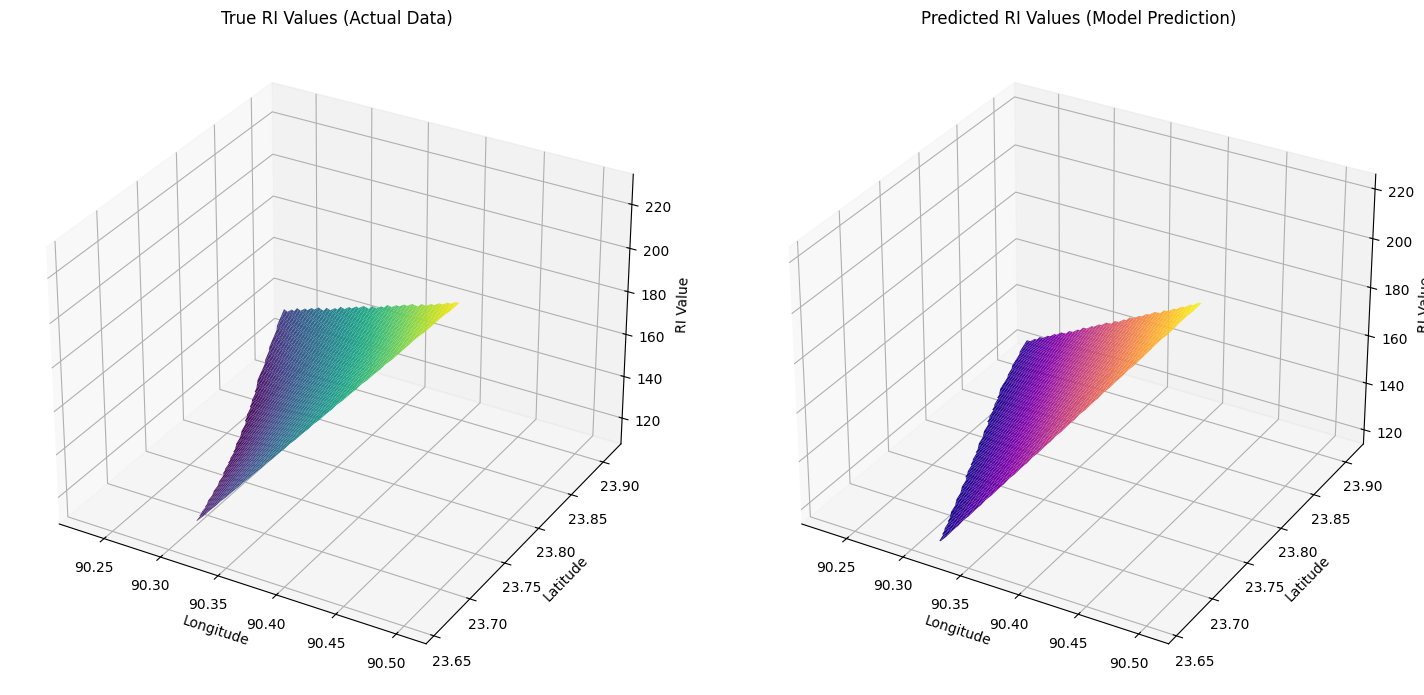

In [12]:
import pandas as pd
import numpy as np
import glob
import os
import rasterio
from sklearn.model_selection import train_test_split
from scipy.spatial import distance_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Concatenate, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import Sequence
import tensorflow as tf
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.interpolate import griddata
import gc
import sys
from io import StringIO
import pickle
from lime import lime_tabular
import lime

# ==================== 1. Load Data ==================== #
# We load the full datasets, including columns for both MLP and GNN branches.
orig = pd.read_csv("../../data/WinterSeason1.csv")
river_100 = pd.read_csv("../data/Samples_100W.csv")

# Define columns for the MLP branch (numeric features) and GNN branch (coordinates)
mlp_cols = list(orig.drop(columns=['Stations','River','Lat','Long','geometry', 'RI']).columns)
coord_cols = ['Long', 'Lat']

# ==================== 2. Collect Rasters and Extract Pixel Values ==================== #
raster_paths = []
raster_paths += glob.glob("../CalIndices/*.tif")
raster_paths += glob.glob("../LULCMerged/*.tif")
raster_paths += glob.glob("../IDWW/*.tif")

print("Rasters will be extracted pixel-by-pixel and added to the MLP branch features.")
print(f"Found {len(raster_paths)} rasters.")

def extract_raster_pixels(df, raster_paths):
    """
    Extracts a single pixel value for each point from each raster and adds
    it as a new column to the dataframe. The new column name is the raster filename.
    """
    df_copy = df.copy()
    raster_names = []
    for i, path in enumerate(raster_paths):
        # Use the base filename as the column name for clarity
        new_col_name = os.path.basename(path)
        raster_names.append(new_col_name)
        values = []
        with rasterio.open(path) as src:
            for _, row in df.iterrows():
                coords = (row['Long'], row['Lat'])
                try:
                    # Get the pixel value at the point's coordinates
                    val = next(src.sample([coords]))[0]
                    # Check if the extracted value is NaN and replace it
                    if np.isnan(val):
                        val = 0
                except Exception as e:
                    # Handle cases where the point is outside the raster
                    val = 0
                values.append(val)
            df_copy[new_col_name] = values
            
    return df_copy, raster_names

# ==================== 3. Create a Custom Data Generator ==================== #
class DataGenerator(Sequence):
    """
    Data generator to handle MLP and GNN inputs.
    """
    def __init__(self, mlp_data, gnn_data, y, batch_size=4, shuffle=True, **kwargs):
        super().__init__(**kwargs)
        self.mlp_data = mlp_data
        self.gnn_data = gnn_data
        self.y = y
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indices = np.arange(len(self.y))
        self.on_epoch_end()

    def __len__(self):
        """Returns the number of batches per epoch."""
        return int(np.floor(len(self.y) / self.batch_size))

    def on_epoch_end(self):
        """Updates indices after each epoch for shuffling."""
        if self.shuffle:
            np.random.shuffle(self.indices)
            
    def __getitem__(self, index):
        """Generates one batch of data."""
        # Get batch indices
        batch_indices = self.indices[index * self.batch_size:(index + 1) * self.batch_size]

        # Get batch data
        batch_mlp = self.mlp_data[batch_indices]
        batch_gnn = self.gnn_data[batch_indices, :]
        batch_y = self.y[batch_indices]
        
        return (batch_mlp, batch_gnn), batch_y

# ==================== 4. Define GNN-MLP Fusion Model ==================== #
def build_fusion_model(mlp_dim, gnn_dim):
    """
    Builds the GNN-MLP fusion model.
    """
    # Inputs for both branches
    mlp_input = Input(shape=(mlp_dim,), name="mlp_input")
    gnn_input = Input(shape=(gnn_dim,), name="gnn_input")
    
    # --- MLP Branch ---
    mlp_branch = Dense(128, activation="relu", name="mlp_dense1")(mlp_input)
    mlp_branch = Dense(64, activation="relu", name="mlp_dense2")(mlp_branch)

    # --- GNN Branch ---
    gnn_branch = Dense(128, activation="relu", name="gnn_dense1")(gnn_input)
    gnn_branch = Dense(64, activation="relu", name="gnn_dense2")(gnn_branch)
    
    # --- Fusion and Prediction ---
    merged = Concatenate()([mlp_branch, gnn_branch])
    
    f = Dense(128, activation="relu")(merged)
    f = Dropout(0.4)(f)
    f = Dense(64, activation="relu")(f)
    output = Dense(1, activation="linear", name="final_output")(f)

    # Build and compile the model
    model = Model(inputs=[mlp_input, gnn_input], outputs=output)
    model.compile(optimizer=Adam(learning_rate=0.0005), loss="mse")
    return model

# ==================== 5. Define Evaluation and Importance Metrics ==================== #
def smape(y_true, y_pred):
    """
    Calculates the Symmetric Mean Absolute Percentage Error (SMAPE).
    """
    numerator = np.abs(y_pred - y_true)
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2.0
    # Add a small epsilon to avoid division by zero
    return np.mean(numerator / (denominator + 1e-8)) * 100

def evaluate_model(model, mlp_test, gnn_test_matrix, y_test, return_preds=False):
    """
    Evaluates the model on given data and returns R², RMSE, MAE, and SMAPE.
    """
    y_pred = model.predict((mlp_test, gnn_test_matrix)).flatten()
    
    if return_preds:
        return y_pred
    else:
        r2 = r2_score(y_test, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        mae = mean_absolute_error(y_test, y_pred)
        smape_score = smape(y_test, y_pred)
        return r2, rmse, mae, smape_score

def calculate_permutation_importance(model, mlp_data, gnn_data, y_true, feature_names):
    """
    Calculates permutation feature importance for each individual feature and the GNN branch.
    """
    # Get baseline R² on the unshuffled data
    baseline_r2, _, _, _ = evaluate_model(model, mlp_data, gnn_data, y_true)
    importance = {}
    
    # Permute each MLP input feature individually
    for i, feature in enumerate(feature_names):
        shuffled_mlp_data = mlp_data.copy()
        np.random.shuffle(shuffled_mlp_data[:, i])
        shuffled_r2, _, _, _ = evaluate_model(model, shuffled_mlp_data, gnn_data, y_true)
        importance[feature] = baseline_r2 - shuffled_r2
    
    # Permute GNN input
    shuffled_gnn_data = gnn_data.copy()
    np.random.shuffle(shuffled_gnn_data)
    shuffled_r2, _, _, _ = evaluate_model(model, mlp_data, shuffled_gnn_data, y_true)
    importance['GNN'] = baseline_r2 - shuffled_r2
    
    return importance

# ==================== 6. Main Execution ==================== #
print("\n" + "="*80)
print("Analyzing GNN-MLP Model with Pixel-Based Raster Features")
print("="*80)


# --- Data Splitting and Feature Extraction ---
# First, split the main 'orig' dataset into training and testing sets.
X_train_orig, X_test_orig, y_train_orig, y_test_orig = train_test_split(
    orig, orig['RI'], test_size=0.2, random_state=42
)

# Now, combine the 'river_100' data into the training set.
X_train = pd.concat([river_100, X_train_orig], ignore_index=True)
y_train = pd.concat([river_100['RI'], y_train_orig], ignore_index=True)
X_test = X_test_orig
y_test = y_test_orig

# --- Prepare Inputs for both branches ---

# 1. Raster Feature Extraction and MLP Input
print("\nExtracting pixel values from rasters...")
X_train, raster_names = extract_raster_pixels(X_train, raster_paths)
X_test, _ = extract_raster_pixels(X_test, raster_paths)
print("Raster pixel values extracted.")

# Update the mlp_cols list with the new raster names
mlp_cols = list(orig.drop(columns=['Stations','River','Lat','Long','geometry', 'RI']).columns) + raster_names

scaler = StandardScaler()
mlp_train = scaler.fit_transform(X_train[mlp_cols])
mlp_test = scaler.transform(X_test[mlp_cols])

# 2. GNN Input: Spatial coordinates
coords_train = X_train[coord_cols].values
coords_test = X_test[coord_cols].values
dist_mat_train = distance_matrix(coords_train, coords_train)
gnn_train = np.exp(-dist_mat_train/10)
dist_mat_test_train = distance_matrix(coords_test, coords_train)
gnn_test = np.exp(-dist_mat_test_train/10)

# --- Model Building and Training ---
gnn_input_dim = len(coords_train)
mlp_input_dim = mlp_train.shape[1]

train_generator = DataGenerator(
    mlp_data=mlp_train, gnn_data=gnn_train, y=y_train.values,
    batch_size=4, shuffle=True
)




# --- Model Evaluation ---
r2, rmse, mae, smape_score = evaluate_model(model, mlp_test, gnn_test, y_test.values)

print("\n" + "="*80)
print("Model Evaluation on Test Set")
print("="*80)
print(f"R²: {r2:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"SMAPE: {smape_score:.4f}%")


# ==================== 7. 3D Surface Plot of True vs. Predicted RI ==================== #
print("\n" + "="*80)
print("Generating 3D Surface Plot of True vs. Predicted RI")
print("="*80)

# Make predictions on the test set
y_pred = evaluate_model(model, mlp_test, gnn_test, y_test.values, return_preds=True)

# Get coordinates from the test set
long = X_test['Long'].values
lat = X_test['Lat'].values

# Create a grid for the surface plot
long_grid = np.linspace(min(long), max(long), 100)
lat_grid = np.linspace(min(lat), max(lat), 100)
long_grid, lat_grid = np.meshgrid(long_grid, lat_grid)

# Interpolate the data to the grid
true_ri_grid = griddata((long, lat), y_test, (long_grid, lat_grid), method='cubic')
pred_ri_grid = griddata((long, lat), y_pred, (long_grid, lat_grid), method='cubic')

# Create the 3D plot
fig = plt.figure(figsize=(15, 7))

# --- True RI Surface Plot ---
ax1 = fig.add_subplot(121, projection='3d')
ax1.plot_surface(long_grid, lat_grid, true_ri_grid, cmap='viridis', edgecolor='none')
ax1.set_title('True RI Values (Actual Data)')
ax1.set_xlabel('Longitude')
ax1.set_ylabel('Latitude')
ax1.set_zlabel('RI Value')

# --- Predicted RI Surface Plot ---
ax2 = fig.add_subplot(122, projection='3d')
ax2.plot_surface(long_grid, lat_grid, pred_ri_grid, cmap='plasma', edgecolor='none')
ax2.set_title('Predicted RI Values (Model Prediction)')
ax2.set_xlabel('Longitude')
ax2.set_ylabel('Latitude')
ax2.set_zlabel('RI Value')

plt.tight_layout()
print("3D surface plot saved as 'ri_surface_plot.png'.")
print("To view the plot, check the output directory.")
plt.show()

In [14]:
true_ri_grid, pred_ri_grid

(array([[         nan,          nan,          nan, ...,          nan,
                  nan,          nan],
        [         nan,          nan,          nan, ...,          nan,
                  nan,          nan],
        [         nan,          nan,          nan, ...,          nan,
                  nan,          nan],
        ...,
        [         nan, 132.67333531, 134.66082337, ...,          nan,
                  nan,          nan],
        [         nan, 133.95835455,          nan, ...,          nan,
                  nan,          nan],
        [133.26      ,          nan,          nan, ...,          nan,
                  nan,          nan]]),
 array([[         nan,          nan,          nan, ...,          nan,
                  nan,          nan],
        [         nan,          nan,          nan, ...,          nan,
                  nan,          nan],
        [         nan,          nan,          nan, ...,          nan,
                  nan,          nan],
        ...,


In [16]:
y_pred, y_test

(array([122.85687 , 116.692696, 116.404594, 224.96645 ], dtype=float32),
 0     133.26
 1     115.16
 5     120.30
 15    232.42
 Name: RI, dtype: float64)

In [21]:
import pandas as pd
import numpy as np
import glob
import os
import rasterio
from sklearn.model_selection import train_test_split
from scipy.spatial import distance_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Concatenate, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import Sequence
import tensorflow as tf
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.interpolate import griddata
import gc
import sys
from io import StringIO
import pickle
from lime import lime_tabular
import lime

# ==================== 1. Load Data ==================== #
# We load the full datasets, including columns for both MLP and GNN branches.
orig = pd.read_csv("../../data/WinterSeason1.csv")
river_100 = pd.read_csv("../data/Samples_100W.csv")

# Define columns for the MLP branch (numeric features) and GNN branch (coordinates)
mlp_cols = list(orig.drop(columns=['Stations','River','Lat','Long','geometry', 'RI']).columns)
coord_cols = ['Long', 'Lat']

# ==================== 2. Collect Rasters and Extract Pixel Values ==================== #
raster_paths = []
raster_paths += glob.glob("../CalIndices/*.tif")
raster_paths += glob.glob("../LULCMerged/*.tif")
raster_paths += glob.glob("../IDWW/*.tif")

print("Rasters will be extracted pixel-by-pixel and added to the MLP branch features.")
print(f"Found {len(raster_paths)} rasters.")

def extract_raster_pixels(df, raster_paths):
    """
    Extracts a single pixel value for each point from each raster and adds
    it as a new column to the dataframe. The new column name is the raster filename.
    """
    df_copy = df.copy()
    raster_names = []
    for i, path in enumerate(raster_paths):
        # Use the base filename as the column name for clarity
        new_col_name = os.path.basename(path)
        raster_names.append(new_col_name)
        values = []
        with rasterio.open(path) as src:
            for _, row in df.iterrows():
                coords = (row['Long'], row['Lat'])
                try:
                    # Get the pixel value at the point's coordinates
                    val = next(src.sample([coords]))[0]
                    # Check if the extracted value is NaN and replace it
                    if np.isnan(val):
                        val = 0
                except Exception as e:
                    # Handle cases where the point is outside the raster
                    val = 0
                values.append(val)
            df_copy[new_col_name] = values
            
    return df_copy, raster_names

# ==================== 3. Create a Custom Data Generator ==================== #
class DataGenerator(Sequence):
    """
    Data generator to handle MLP and GNN inputs.
    """
    def __init__(self, mlp_data, gnn_data, y, batch_size=4, shuffle=True, **kwargs):
        super().__init__(**kwargs)
        self.mlp_data = mlp_data
        self.gnn_data = gnn_data
        self.y = y
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indices = np.arange(len(self.y))
        self.on_epoch_end()

    def __len__(self):
        """Returns the number of batches per epoch."""
        return int(np.floor(len(self.y) / self.batch_size))

    def on_epoch_end(self):
        """Updates indices after each epoch for shuffling."""
        if self.shuffle:
            np.random.shuffle(self.indices)
            
    def __getitem__(self, index):
        """Generates one batch of data."""
        # Get batch indices
        batch_indices = self.indices[index * self.batch_size:(index + 1) * self.batch_size]

        # Get batch data
        batch_mlp = self.mlp_data[batch_indices]
        batch_gnn = self.gnn_data[batch_indices, :]
        batch_y = self.y[batch_indices]
        
        return (batch_mlp, batch_gnn), batch_y

# ==================== 4. Define GNN-MLP Fusion Model ==================== #
def build_fusion_model(mlp_dim, gnn_dim):
    """
    Builds the GNN-MLP fusion model.
    """
    # Inputs for both branches
    mlp_input = Input(shape=(mlp_dim,), name="mlp_input")
    gnn_input = Input(shape=(gnn_dim,), name="gnn_input")
    
    # --- MLP Branch ---
    mlp_branch = Dense(128, activation="relu", name="mlp_dense1")(mlp_input)
    mlp_branch = Dense(64, activation="relu", name="mlp_dense2")(mlp_branch)

    # --- GNN Branch ---
    gnn_branch = Dense(128, activation="relu", name="gnn_dense1")(gnn_input)
    gnn_branch = Dense(64, activation="relu", name="gnn_dense2")(gnn_branch)
    
    # --- Fusion and Prediction ---
    merged = Concatenate()([mlp_branch, gnn_branch])
    
    f = Dense(128, activation="relu")(merged)
    f = Dropout(0.4)(f)
    f = Dense(64, activation="relu")(f)
    output = Dense(1, activation="linear", name="final_output")(f)

    # Build and compile the model
    model = Model(inputs=[mlp_input, gnn_input], outputs=output)
    model.compile(optimizer=Adam(learning_rate=0.0005), loss="mse")
    return model

# ==================== 5. Define Evaluation and Importance Metrics ==================== #
def smape(y_true, y_pred):
    """
    Calculates the Symmetric Mean Absolute Percentage Error (SMAPE).
    """
    numerator = np.abs(y_pred - y_true)
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2.0
    # Add a small epsilon to avoid division by zero
    return np.mean(numerator / (denominator + 1e-8)) * 100

def evaluate_model(model, mlp_test, gnn_test_matrix, y_test, return_preds=False):
    """
    Evaluates the model on given data and returns R², RMSE, MAE, and SMAPE.
    """
    y_pred = model.predict((mlp_test, gnn_test_matrix)).flatten()
    
    if return_preds:
        return y_pred
    else:
        r2 = r2_score(y_test, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        mae = mean_absolute_error(y_test, y_pred)
        smape_score = smape(y_test, y_pred)
        return r2, rmse, mae, smape_score

def calculate_permutation_importance(model, mlp_data, gnn_data, y_true, feature_names):
    """
    Calculates permutation feature importance for each individual feature and the GNN branch.
    """
    # Get baseline R² on the unshuffled data
    baseline_r2, _, _, _ = evaluate_model(model, mlp_data, gnn_data, y_true)
    importance = {}
    
    # Permute each MLP input feature individually
    for i, feature in enumerate(feature_names):
        shuffled_mlp_data = mlp_data.copy()
        np.random.shuffle(shuffled_mlp_data[:, i])
        shuffled_r2, _, _, _ = evaluate_model(model, shuffled_mlp_data, gnn_data, y_true)
        importance[feature] = baseline_r2 - shuffled_r2
    
    # Permute GNN input
    shuffled_gnn_data = gnn_data.copy()
    np.random.shuffle(shuffled_gnn_data)
    shuffled_r2, _, _, _ = evaluate_model(model, mlp_data, shuffled_gnn_data, y_true)
    importance['GNN'] = baseline_r2 - shuffled_r2
    
    return importance

# ==================== 6. Main Execution ==================== #
print("\n" + "="*80)
print("Analyzing GNN-MLP Model with Pixel-Based Raster Features")
print("="*80)


# --- Data Splitting and Feature Extraction ---
# Split the main 'orig' dataset into training, validation, and testing sets.
# The split is 80% for training, and 10% each for validation and testing.
X_train_orig, X_temp_orig, y_train_orig, y_temp_orig = train_test_split(
    orig, orig['RI'], test_size=0.2, random_state=42
)
X_val_orig, X_test_orig, y_val_orig, y_test_orig = train_test_split(
    X_temp_orig, y_temp_orig, test_size=0.5, random_state=42
)

# Now, combine the 'river_100' data into the training set.
X_train = pd.concat([river_100, X_train_orig], ignore_index=True)
y_train = pd.concat([river_100['RI'], y_train_orig], ignore_index=True)
X_test = X_test_orig
y_test = y_test_orig
X_val = X_val_orig
y_val = y_val_orig

# --- Prepare Inputs for both branches ---

# 1. Raster Feature Extraction and MLP Input
print("\nExtracting pixel values from rasters...")
X_train, raster_names = extract_raster_pixels(X_train, raster_paths)
X_test, _ = extract_raster_pixels(X_test, raster_paths)
X_val, _ = extract_raster_pixels(X_val, raster_paths)
print("Raster pixel values extracted.")

# Update the mlp_cols list with the new raster names
mlp_cols = list(orig.drop(columns=['Stations','River','Lat','Long','geometry', 'RI']).columns) + raster_names

scaler = StandardScaler()
mlp_train = scaler.fit_transform(X_train[mlp_cols])
mlp_test = scaler.transform(X_test[mlp_cols])
mlp_val = scaler.transform(X_val[mlp_cols])

# 2. GNN Input: Spatial coordinates
coords_train = X_train[coord_cols].values
coords_test = X_test[coord_cols].values
coords_val = X_val[coord_cols].values

dist_mat_train = distance_matrix(coords_train, coords_train)
gnn_train = np.exp(-dist_mat_train/10)
dist_mat_test_train = distance_matrix(coords_test, coords_train)
gnn_test = np.exp(-dist_mat_test_train/10)
dist_mat_val_train = distance_matrix(coords_val, coords_train)
gnn_val = np.exp(-dist_mat_val_train/10)

# --- Model Building and Training ---
gnn_input_dim = len(coords_train)
mlp_input_dim = mlp_train.shape[1]

train_generator = DataGenerator(
    mlp_data=mlp_train, gnn_data=gnn_train, y=y_train.values,
    batch_size=4, shuffle=True
)

val_generator = DataGenerator(
    mlp_data=mlp_val, gnn_data=gnn_val, y=y_val.values,
    batch_size=4, shuffle=False
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True
)



# --- Model Evaluation ---
# Evaluate on the dedicated test set.
r2, rmse, mae, smape_score = evaluate_model(model, mlp_test, gnn_test, y_test.values)

print("\n" + "="*80)
print("Model Evaluation on Test Set")
print("="*80)
print(f"R²: {r2:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"SMAPE: {smape_score:.4f}%")


# ==================== 7. 3D Surface Plot of True vs. Predicted RI ==================== #
print("\n" + "="*80)
print("Generating 3D Surface Plot of True vs. Predicted RI (Validation Data)")
print("="*80)

# Make predictions on the validation set for plotting
y_pred_val = evaluate_model(model, mlp_val, gnn_val, y_val.values, return_preds=True)

# Get coordinates from the validation set
long = X_val['Long'].values
lat = X_val['Lat'].values

# Determine interpolation method based on number of points
interpolation_method = 'cubic'
if len(np.unique(coords_val, axis=0)) < 4:
    interpolation_method = 'linear'
    print(f"Warning: Not enough unique points for cubic interpolation. Using '{interpolation_method}' instead.")

# Create a grid for the surface plot
long_grid = np.linspace(min(long), max(long), 100)
lat_grid = np.linspace(min(lat), max(lat), 100)
long_grid, lat_grid = np.meshgrid(long_grid, lat_grid)

# Interpolate the data to the grid
true_ri_grid = griddata((long, lat), y_val, (long_grid, lat_grid), method=interpolation_method)
pred_ri_grid = griddata((long, lat), y_pred_val, (long_grid, lat_grid), method=interpolation_method)

# --- New section to handle NaN values ---
# The griddata function produces NaN values for grid points outside the convex hull of the data.
# We replace these NaNs with the mean of the valid values to create a continuous surface.
true_ri_grid = np.nan_to_num(true_ri_grid, nan=np.nanmean(true_ri_grid))
pred_ri_grid = np.nan_to_num(pred_ri_grid, nan=np.nanmean(pred_ri_grid))

# Create the 3D plot
fig = plt.figure(figsize=(15, 7))

# --- True RI Surface Plot ---
ax1 = fig.add_subplot(121, projection='3d')
ax1.plot_surface(long_grid, lat_grid, true_ri_grid, cmap='viridis', edgecolor='none')
ax1.set_title(f'True RI Values (Validation Data, {interpolation_method.capitalize()} Interpolation)')
ax1.set_xlabel('Longitude')
ax1.set_ylabel('Latitude')
ax1.set_zlabel('RI Value')

# --- Predicted RI Surface Plot ---
ax2 = fig.add_subplot(122, projection='3d')
ax2.plot_surface(long_grid, lat_grid, pred_ri_grid, cmap='plasma', edgecolor='none')
ax2.set_title(f'Predicted RI Values (Validation Data, {interpolation_method.capitalize()} Interpolation)')
ax2.set_xlabel('Longitude')
ax2.set_ylabel('Latitude')
ax2.set_zlabel('RI Value')

plt.tight_layout()
plt.savefig('ri_surface_plot.png')
print("3D surface plot saved as 'ri_surface_plot.png'.")
print("To view the plot, check the output directory.")
plt.show()


Rasters will be extracted pixel-by-pixel and added to the MLP branch features.
Found 26 rasters.

Analyzing GNN-MLP Model with Pixel-Based Raster Features

Extracting pixel values from rasters...
Raster pixel values extracted.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

Model Evaluation on Test Set
R²: 0.9916
RMSE: 5.3807
MAE: 4.4931
SMAPE: 2.2907%

Generating 3D Surface Plot of True vs. Predicted RI (Validation Data)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


QhullError: QH6214 qhull input error: not enough points(2) to construct initial simplex (need 4)

While executing:  | qhull d Qt Q12 Qz Qbb Qc
Options selected for Qhull 2019.1.r 2019/06/21:
  run-id 657666494  delaunay  Qtriangulate  Q12-allow-wide  Qz-infinity-point
  Qbbound-last  Qcoplanar-keep  _pre-merge  _zero-centrum  Qinterior-keep
  _maxoutside  0


In [19]:
true_ri_grid.shape, pred_ri_grid

((100, 100),
 array([[153.13300843, 153.13300843, 153.13300843, ..., 153.13300843,
         153.13300843, 153.13300843],
        [153.13300843, 153.13300843, 153.13300843, ..., 153.13300843,
         153.13300843, 153.13300843],
        [153.13300843, 153.13300843, 153.13300843, ..., 153.13300843,
         153.13300843, 153.13300843],
        ...,
        [153.13300843, 123.18759491, 124.65731273, ..., 153.13300843,
         153.13300843, 153.13300843],
        [153.13300843, 123.75695916, 153.13300843, ..., 153.13300843,
         153.13300843, 153.13300843],
        [122.85687256, 153.13300843, 153.13300843, ..., 153.13300843,
         153.13300843, 153.13300843]]))